In [ ]:
import pandas as pd
import tensorflow as tf
import os
import time
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def augmentImages(input_image, real_image):

    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if(tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    if(tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    contrast = tf.random.uniform((), minval = 0.2, maxval=0.5)
    input_image = tf.image.adjust_contrast(input_image,contrast_factor=contrast)
    real_image = tf.image.adjust_contrast(real_image,contrast_factor=contrast)
    hue = tf.random.uniform((), minval = 0.2, maxval=0.3)
    input_image = tf.image.adjust_hue(input_image,hue)
    real_image = tf.image.adjust_hue(real_image,hue)
    brightness = tf.random.uniform((), minval = 0.2, maxval=0.3)
    input_image = tf.image.adjust_brightness(input_image,brightness)
    real_image = tf.image.adjust_brightness(real_image,brightness)

    return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   286, 286)
  input_image, real_image = augmentImages(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   256, 256)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/training/'+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/test_syn/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

(None, None, None)
(None, None, None)


In [ ]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

In [ ]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

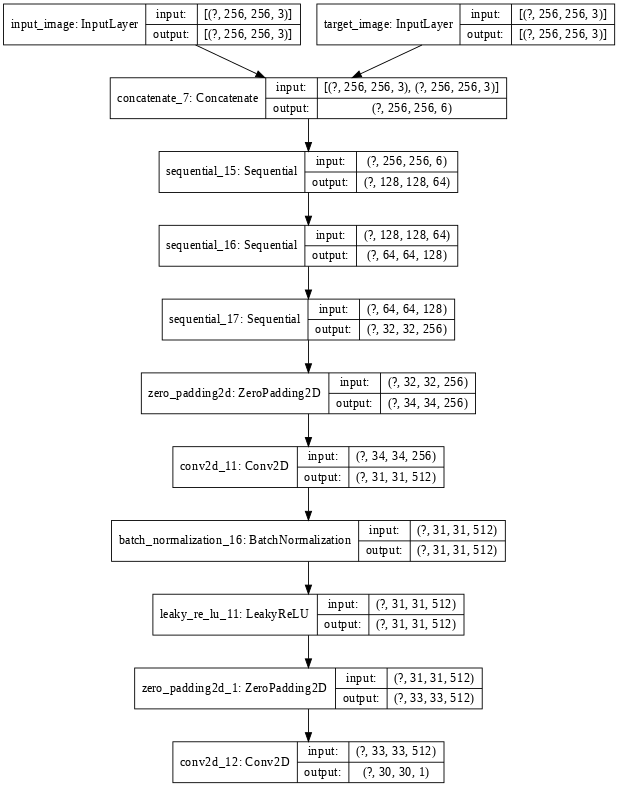

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  return (gen_total_loss, disc_loss)
def fit(train_ds, epochs, test_ds):
  lossHistGen = []
  lossHistDisc = []
  for epoch in range(epochs):
    
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    epochLossGen = []
    epochLossDisc = []
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      genLoss, discLoss = train_step(input_image, target, epoch)
      epochLossGen.append(genLoss)
      epochLossDisc.append(discLoss)
    print()

    print ('Time taken for epoch {} is {} sec and Generator Loss is {} and Discriminator Loss is {}\n'.format(epoch + 1,
                                                        time.time()-start, np.mean(np.array(epochLossGen)), np.mean(np.array(epochLossDisc))))
    lossHistGen.append(np.mean(np.array(epochLossGen)))
    lossHistDisc.append(np.mean(np.array(epochLossDisc)))
  return (lossHistGen, lossHistDisc)  

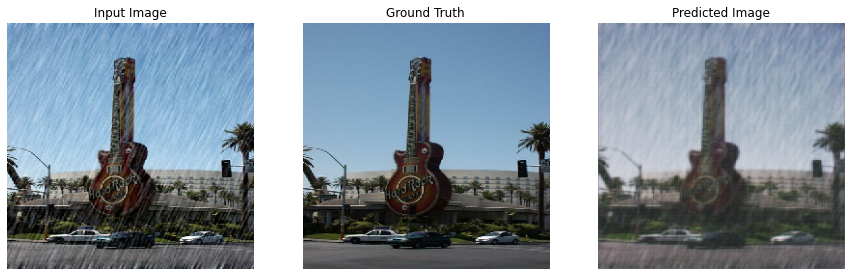

Epoch:  2
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 3 is 68.83874249458313 sec and Generator Loss is 9.405948638916016 and Discriminator Loss is 1.2809020280838013



In [ ]:
genLoss , discLoss = fit(train_dataset, 3, test_dataset)

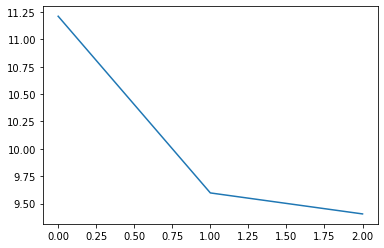

In [ ]:
plt.plot(range(len(genLoss)), genLoss)
plt.show()

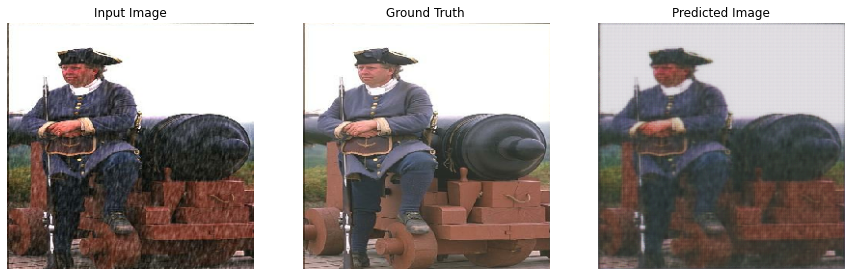

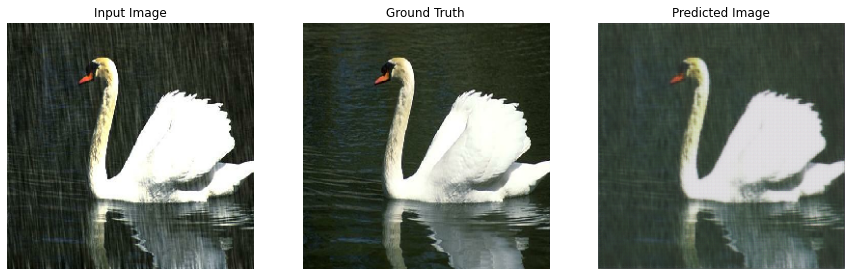

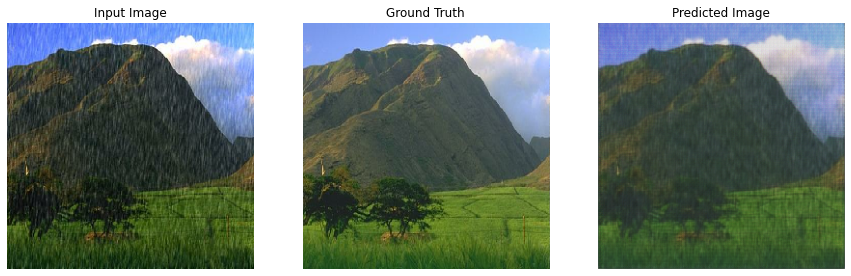

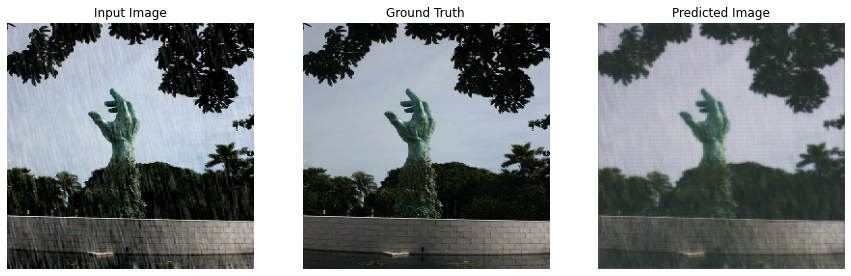

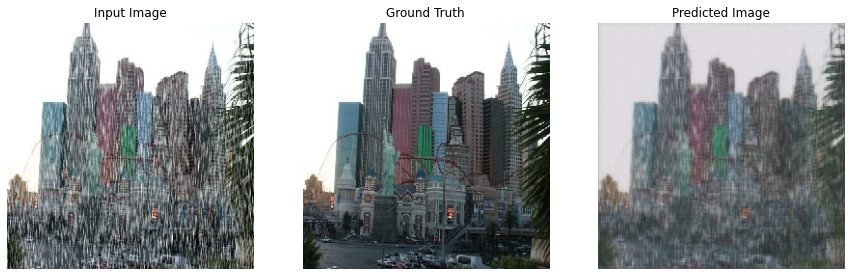

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
generator.save_weights('drive/My Drive/TrainedModels/ImageDerainingGen.h5')
discriminator.save_weights('drive/My Drive/TrainedModels/ImageDerainingDisc.h5')

In [ ]:
import os
train_files = os.listdir('drive/My Drive/rain/training/')
test_syn = os.listdir('drive/My Drive/rain/test_syn/')
test_zeroshot = os.listdir('drive/My Drive/rain/test_nature/')

In [ ]:
print(len(train_files),len(test_syn), len(test_zeroshot))

700 100 52


In [ ]:
generator.load_weights('drive/My Drive/TrainedModels/ImageDerainingGen.h5')

In [ ]:
from skimage.measure import compare_psnr

def calculate_psnr(image_file_path):
    rain_image, ground_truth = load(image_file_path)
    rain_image = (rain_image / 127.5) - 1
    ground_truth = ground_truth / 255.0
    rain_image, ground_truth = resize(rain_image, ground_truth, 256,256)
    rain_image = tf.expand_dims(rain_image, axis = 0)
    gen_output = generator(rain_image)
    gen_output = tf.squeeze(gen_output, axis = 0)
    gen_output = gen_output * 0.5 + 0.5

    psnr_val = compare_psnr(ground_truth.numpy(), gen_output.numpy())
    return psnr_val

In [ ]:
from skimage.measure import compare_ssim

def calculate_ssim(image_file_path):
    rain_image, ground_truth = load(image_file_path)
    rain_image = (rain_image / 127.5) - 1
    ground_truth = ground_truth / 255.0
    rain_image, ground_truth = resize(rain_image, ground_truth, 256,256)
    rain_image = tf.expand_dims(rain_image, axis = 0)
    gen_output = generator(rain_image)
    gen_output = tf.squeeze(gen_output, axis = 0)
    gen_output = gen_output * 0.5 + 0.5

    psnr_val = compare_ssim(ground_truth.numpy(), gen_output.numpy(), multichannel=True)
    return psnr_val

In [ ]:
psnr_vals_test_image = []
for image in test_syn:
    image_path = 'drive/My Drive/rain/test_syn/' + image
    psnr = calculate_psnr(image_path)
    psnr_vals_test_image.append(psnr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


In [ ]:
ssim_vals_test_image = []
for image in test_syn:
    image_path = 'drive/My Drive/rain/test_syn/' + image
    ssim = calculate_ssim(image_path)
    ssim_vals_test_image.append(ssim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


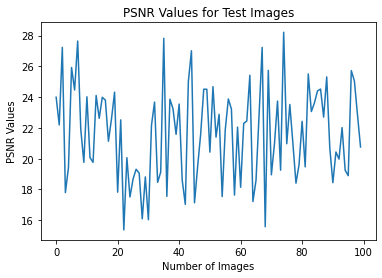

In [ ]:
plt.plot(range(len(psnr_vals_test_image)), psnr_vals_test_image)
plt.xlabel('Number of Images')
plt.ylabel('PSNR Values')
plt.title('PSNR Values for Test Images')
plt.show()

In [ ]:
np.array(psnr_vals_test_image).mean()

21.649385580212826

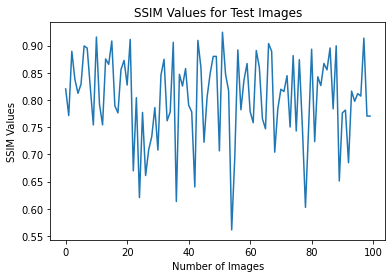

In [ ]:
plt.plot(range(len(ssim_vals_test_image)), ssim_vals_test_image)
plt.xlabel('Number of Images')
plt.ylabel('SSIM Values')
plt.title('SSIM Values for Test Images')
plt.show()

In [ ]:
np.array(ssim_vals_test_image).mean()

0.8038347495459955

In [ ]:
psnr_vals_train = []
for image in train_files:
    image_path = 'drive/My Drive/rain/training/' + image
    try:
        psnr = calculate_psnr(image_path)
        psnr_vals_train.append(psnr)
    except:
        continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


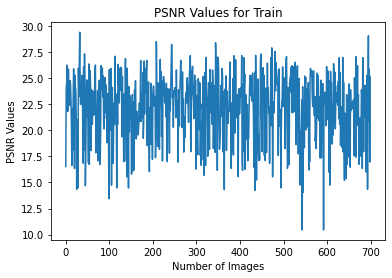

In [ ]:
plt.plot(range(len(psnr_vals_train)), psnr_vals_train)
plt.xlabel('Number of Images')
plt.ylabel('PSNR Values')
plt.title('PSNR Values for Train')
plt.show()

In [ ]:
np.array(psnr_vals_train).mean()

22.18640940832245

In [ ]:
ssim_vals_train = []
for image in train_files:
    image_path = 'drive/My Drive/rain/training/' + image
    try:
        ssim = calculate_ssim(image_path)
        ssim_vals_train.append(ssim)
    except:
        continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


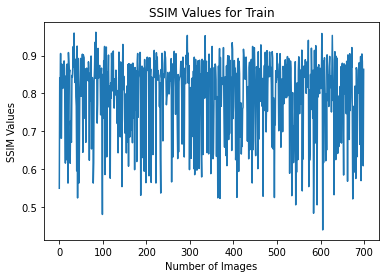

In [ ]:
plt.plot(range(len(ssim_vals_train)), ssim_vals_train)
plt.xlabel('Number of Images')
plt.ylabel('SSIM Values')
plt.title('SSIM Values for Train')
plt.show()

In [ ]:
np.array(ssim_vals_train).mean()

0.7955964528509529

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
test_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/test_nature/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

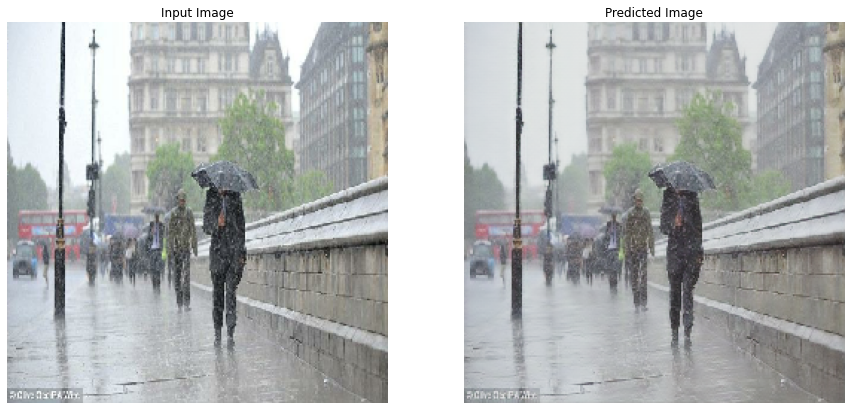

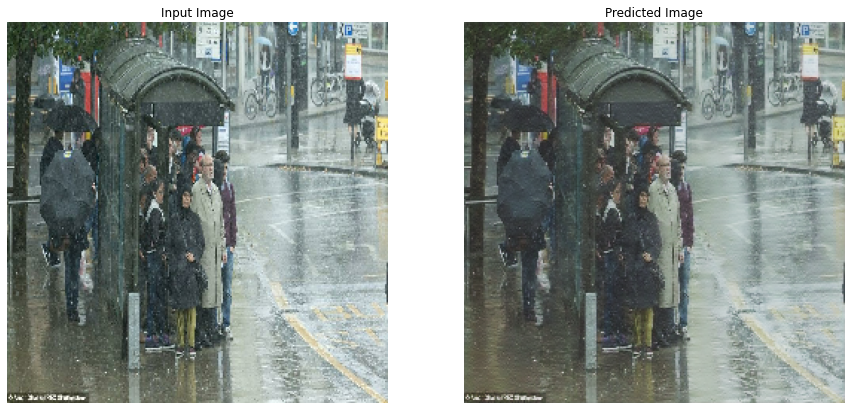

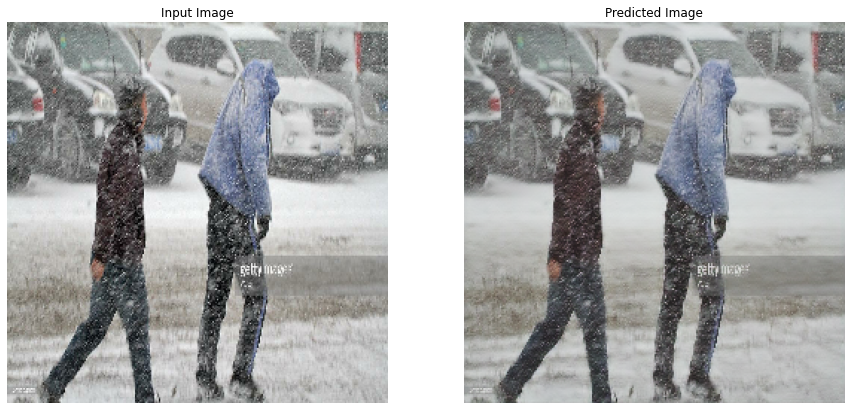

In [ ]:
for example_input, example_target in test_dataset.take(3):
      generate_images(generator, example_input)

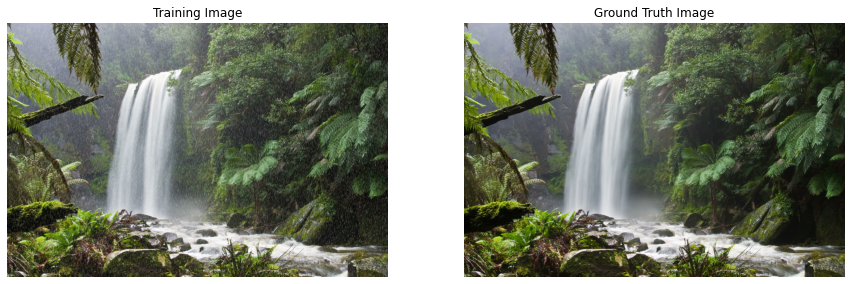

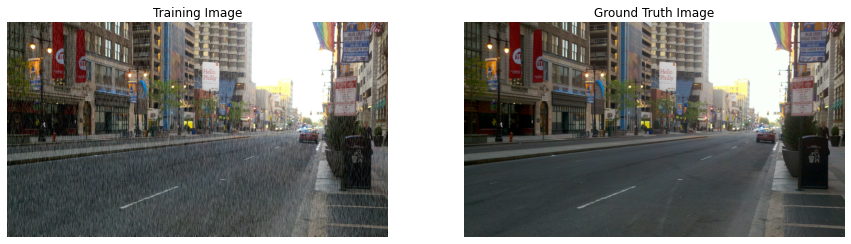

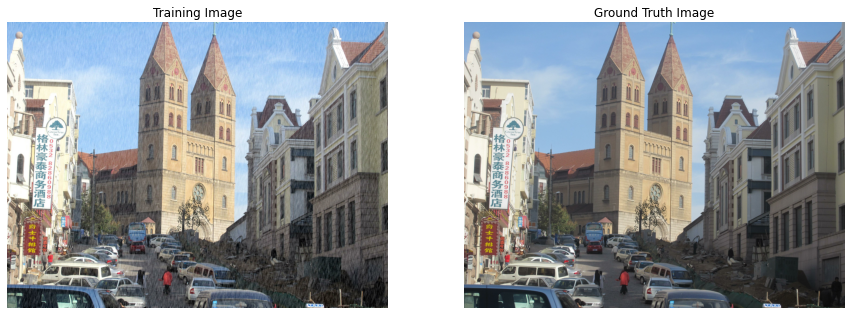

In [ ]:
for image in train_files[1:4]:
    image_path = 'drive/My Drive/rain/training/' + image
    x, y = load(image_path)
    x /= 255.0
    y /= 255.0
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.title('Training Image')
    plt.imshow(x)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Ground Truth Image')
    plt.imshow(y)

    plt.axis('off')
    plt.show()